In [1]:
!pip install PyPDF2 pandas nltk textblob wordcloud gensim scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 131.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=

In [1]:
import PyPDF2
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models


In [2]:
pdf_path = '/content/Nestlé-India-AR-2024-25.pdf'

reader = PyPDF2.PdfReader(open(pdf_path, 'rb'))
text = ""
for page in reader.pages:
    text += page.extract_text()
print(len(text))


853754


In [3]:
data = pd.DataFrame({'Report_Text': [text]})
data.head()

,Report_Text
0,Adversity \nMakes Us \nStrongerNestlé India Li...


In [4]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

data['Clean_Text'] = data['Report_Text'].apply(preprocess)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
nltk.download('punkt')
nltk.download('punkt_iu')
nltk.download('punkt_tab')   # 🔥 Add this new line

sentences = sent_tokenize(data['Clean_Text'][0])

sentiments = []
for s in sentences:
    polarity = TextBlob(s).sentiment.polarity
    sentiments.append({'Sentence': s, 'Polarity': polarity})

sent_df = pd.DataFrame(sentiments)
sent_df['Sentiment'] = sent_df['Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
sent_df.head(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading punkt_iu: Package 'punkt_iu' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Sentence,Polarity,Sentiment
0,adversity makes us strongernestl india limited...,0.079152,Positive


In [7]:
sent_summary = sent_df['Sentiment'].value_counts(normalize=True)*100
print(sent_summary)


Sentiment
Positive    100.0
Name: proportion, dtype: float64


In [8]:
words = word_tokenize(data['Clean_Text'][0])
word_freq = pd.Series(words).value_counts().head(20)
print(word_freq)


company       1343
financial     1012
year           814
st             703
march          673
nestl          597
india          428
ended          414
report         350
value          336
total          327
statements     304
million        294
business       289
tax            285
assets         280
management     259
act            257
board          257
directors      242
Name: count, dtype: int64


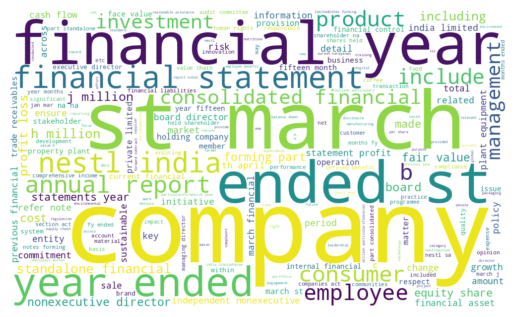

In [9]:
wc = WordCloud(width=1000, height=600, background_color='white').generate(data['Clean_Text'][0])
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


In [10]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform([data['Clean_Text'][0]])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.head()


,access,accessibility,accordance,accordingly,account,accountants,accounting,accounts,accrued,accumulated,...,workforce,working,workinprogress,workplace,world,year,years,yes,yesno,zero
0,0.015988,0.005873,0.023819,0.007178,0.018599,0.00881,0.024472,0.015009,0.005221,0.005547,...,0.008484,0.016967,0.00881,0.010768,0.005547,0.265601,0.053838,0.042418,0.008157,0.0062


In [11]:
tokens = [word_tokenize(data['Clean_Text'][0])]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=10)
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}\n")


Topic 1: 0.018*"company" + 0.014*"financial" + 0.011*"year" + 0.009*"st" + 0.009*"march" + 0.008*"nestl" + 0.006*"india" + 0.006*"ended" + 0.005*"report" + 0.005*"value"

Topic 2: 0.001*"year" + 0.001*"st" + 0.001*"financial" + 0.001*"company" + 0.001*"march" + 0.001*"nestl" + 0.000*"ended" + 0.000*"value" + 0.000*"report" + 0.000*"india"

Topic 3: 0.004*"company" + 0.003*"financial" + 0.002*"march" + 0.002*"st" + 0.002*"year" + 0.002*"nestl" + 0.001*"ended" + 0.001*"india" + 0.001*"million" + 0.001*"report"

Topic 4: 0.002*"company" + 0.001*"financial" + 0.001*"year" + 0.001*"march" + 0.001*"st" + 0.001*"nestl" + 0.001*"ended" + 0.001*"india" + 0.001*"total" + 0.001*"business"

Topic 5: 0.002*"company" + 0.001*"financial" + 0.001*"year" + 0.001*"march" + 0.001*"st" + 0.001*"nestl" + 0.001*"ended" + 0.000*"india" + 0.000*"statements" + 0.000*"total"

Topic 6: 0.001*"company" + 0.001*"financial" + 0.001*"march" + 0.001*"st" + 0.001*"nestl" + 0.001*"year" + 0.001*"ended" + 0.000*"report"

In [13]:
!pip install pyLDAvis



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.2 MB/s eta 0:00:00


In [14]:
import pyLDAvis.gensim
import pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
0     -0.178323  2.565274e-08       1        1  99.998781
2     -0.017777 -4.823111e-06       2        1   0.000135
3      0.014701 -6.513821e-06       3        1   0.000135
8      0.018817  1.405191e-04       4        1   0.000135
4      0.020970 -8.595842e-05       5        1   0.000135
6      0.024365 -2.251088e-05       6        1   0.000135
7      0.025601 -5.253034e-07       7        1   0.000135
9      0.029363 -4.459289e-05       8        1   0.000135
5      0.029782 -9.263418e-05       9        1   0.000135
1      0.032502  1.170139e-04      10        1   0.000135, topic_info=           Term         Freq        Total Category  logprob  loglift
1187    company  1331.000000  1331.000000  Default  30.0000  30.0000
2536  financial  1003.000000  1003.000000  Default  29.0000  29.0000
7382       year   806.000000   806.000000  Default  28.0000  28.0000
6336         st   696.000000   696.000000  Default  27.0000  27.0000
3995      march   666.000000   666.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6789      total     0.000031   324.305918  Topic10  -8.0835  -2.6546
3410   interest     0.000029   197.221096  Topic10  -8.1622  -2.2359
529           b     0.000028   171.562061  Topic10  -8.1910  -2.1253
2903          h     0.000028   208.077883  Topic10  -8.1726  -2.2999
6693         th     0.000029   232.020327  Topic10  -8.1589  -2.3950

[740 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
29        1  0.928268            acceptable
79        1  1.000100                   act
94        1  0.928722           actpurchase
168       1  0.930051                affair
185       1  0.929609  africapenetrationled
...     ...       ...                   ...
7392      1  0.928011     yearremarksnumber
7395      1  1.002294                 years
7401      1  0.928339                yellow
7409      1  0.930891             yesterday
7414      1  0.931282                  ynna

[322 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 9, 5, 7, 8, 10, 6, 2])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
